In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from random import seed
from skimage.io import imread,imshow
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
import tensorboard
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

## Preparing images for the input layer

In [13]:
seed = 42

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3


TRAIN_PATH = '../../../../../../../Applications/PHYS499/UNET/dataset01_1695/stage1_train/'

train_ids = next(os.walk(TRAIN_PATH))[1]

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)


print('Resizing training images and masks')
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/mask/' + id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
    Y_train[n] = mask_


Resizing training images and masks


100%|███████████████████████████████████████| 1695/1695 [01:14<00:00, 22.71it/s]


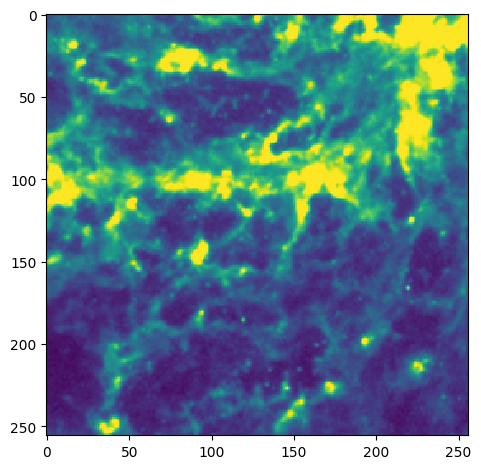

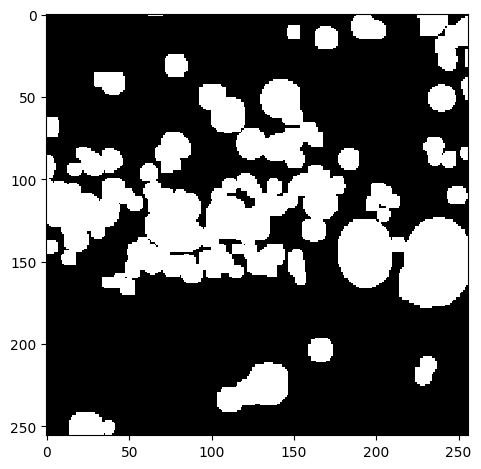

In [16]:
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# U-NET Architecture

In [4]:
def conv2d_block(input_tensor, n_filters, dropout=0.1,kernel_size=3,batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    #first layer
    x = Conv2D(filters = n_filters, kernel_size= (kernel_size,kernel_size),
               kernel_initializer = 'he_normal',padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Middle Layer
    x = Dropout(dropout)(x)
    
    #second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size,kernel_size),
              kernel_initializer='he_normal',padding='same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [5]:
def get_unet(input_img,n_filters = 16,batchnorm = True):
    
    #Contracting Path
    c1 = conv2d_block(input_img,n_filters*1,kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = conv2d_block(p1,n_filters*2,kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = conv2d_block(p2,n_filters*4,kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = conv2d_block(p3,n_filters*8,dropout=0.2,kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = conv2d_block(p4,n_filters=n_filters*16,dropout=0.3, kernel_size=3, batchnorm=batchnorm)

    #Expansive path
    u6 = Conv2DTranspose(n_filters*8,(3,3),strides= (2,2),padding='same')(c5)
    u6 = concatenate([u6,c4])
    c6 = conv2d_block(u6,n_filters*8,kernel_size=3,batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*4,(3,3),strides= (2,2),padding='same')(c6)
    u7 = concatenate([u7,c3])
    c7 = conv2d_block(u7,n_filters*4,kernel_size=3,batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*2,(3,3),strides= (2,2),padding='same')(c7)
    u8 = concatenate([u8,c2])
    c8 = conv2d_block(u8,n_filters*4,kernel_size=3,batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*1,(3,3),strides= (2,2),padding='same')(c8)
    u9 = concatenate([u9,c1])
    c9 = conv2d_block(u9,n_filters*1,kernel_size=3,batchnorm=batchnorm)

    outputs = Conv2D(1,(1,1),activation='sigmoid')(c9)
    model = Model(inputs=[input_img],outputs=[outputs])
    return model


In [6]:
inputs = Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
input_image = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
model = get_unet(input_image,n_filters=16,batchnorm=True)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

Metal device set to: Apple M1


2023-04-12 13:51:14.483371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-12 13:51:14.483563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[1][0]']               
 rmalization)                   )                                                             

 concatenate_2 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_2[1][0]',     
                                )                                 'activation_3[1][0]']           
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 64  36928       ['concatenate_2[1][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 64  256        ['conv2d_15[1][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_15 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_15[1][0]'] 
          

In [8]:
callbacks = [
    EarlyStopping(patience=50,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    ModelCheckpoint('../Saved Models/1695.h5',verbose=1,save_best_only=True)
]

results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=32,epochs=50,callbacks=callbacks)

Epoch 1/50


2023-04-12 13:51:32.590892: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-12 13:51:33.667105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.7463

2023-04-12 13:52:26.957088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 6.76786, saving model to ../Saved Models/1695.h5
48/48 [==============================] - 57s 1s/step - loss: 0.5232 - accuracy: 0.7463 - val_loss: 6.7679 - val_accuracy: 0.3641
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8472
Epoch 2: val_loss improved from 6.76786 to 0.66057, saving model to ../Saved Models/1695.h5
48/48 [==============================] - 53s 1s/step - loss: 0.3638 - accuracy: 0.8472 - val_loss: 0.6606 - val_accuracy: 0.7340
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8917
Epoch 3: val_loss improved from 0.66057 to 0.58053, saving model to ../Saved Models/1695.h5
48/48 [==============================] - 53s 1s/step - loss: 0.2696 - accuracy: 0.8917 - val_loss: 0.5805 - val_accuracy: 0.7721
Epoch 4/50
48/48 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9163
Epoch 4: val_loss improved from 0.58053 to 0.50942, saving

48/48 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9782
Epoch 28: val_loss did not improve from 0.06673
48/48 [==============================] - 51s 1s/step - loss: 0.0535 - accuracy: 0.9782 - val_loss: 0.1173 - val_accuracy: 0.9582
Epoch 29/50
48/48 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9814
Epoch 29: val_loss improved from 0.06673 to 0.06664, saving model to ../Saved Models/1695.h5
48/48 [==============================] - 54s 1s/step - loss: 0.0449 - accuracy: 0.9814 - val_loss: 0.0666 - val_accuracy: 0.9742
Epoch 30/50
48/48 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9841
Epoch 30: val_loss did not improve from 0.06664
48/48 [==============================] - 54s 1s/step - loss: 0.0386 - accuracy: 0.9841 - val_loss: 0.0696 - val_accuracy: 0.9734
Epoch 31/50
48/48 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9845
Epoch 31: val_loss improved from 0.06664 to 0.06172, sav

2023-04-12 14:39:55.358965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 403ms/step


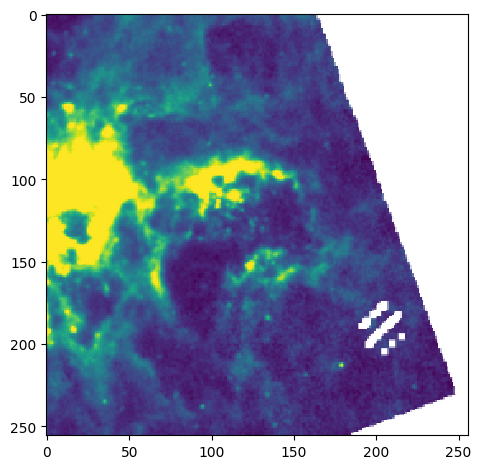

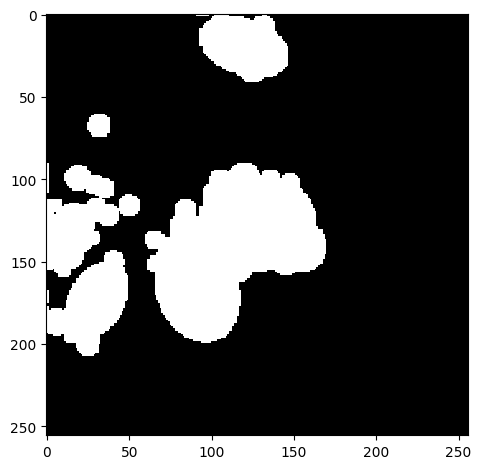

/Users/dhananjhaybansal/Library/Python/3.9/lib/python/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


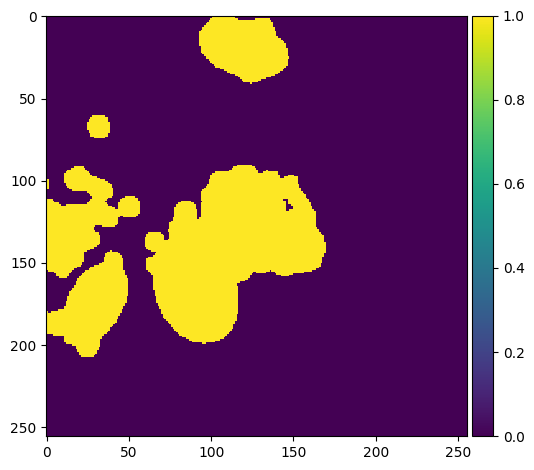

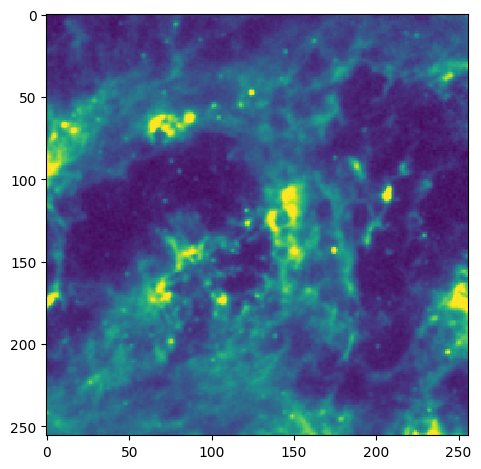

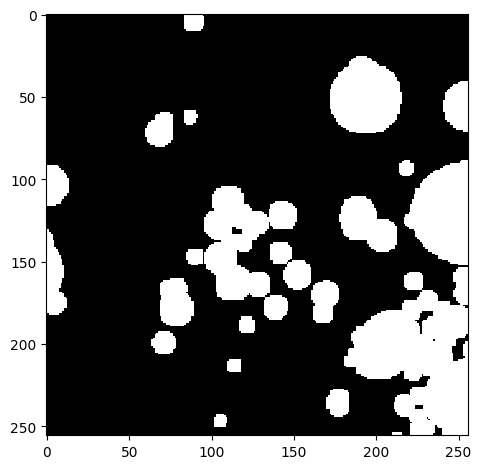

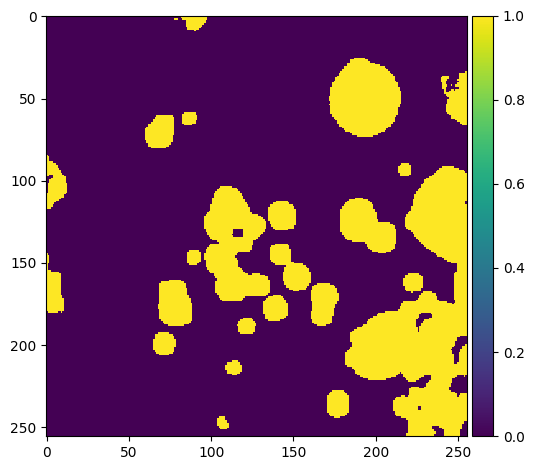

In [9]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)

#binary
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()

ix = random.randint(0,len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()


# Overlaying with the prediction contour lines 

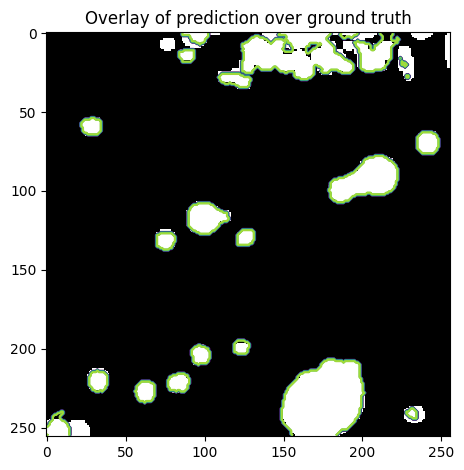

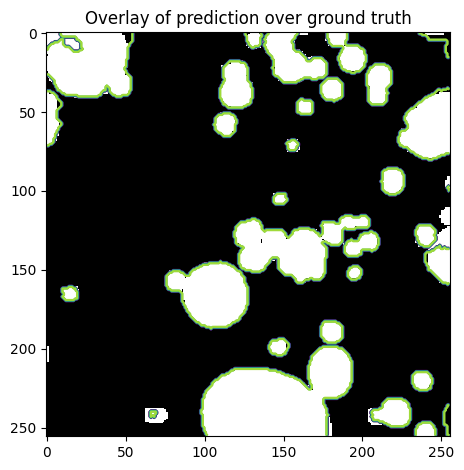

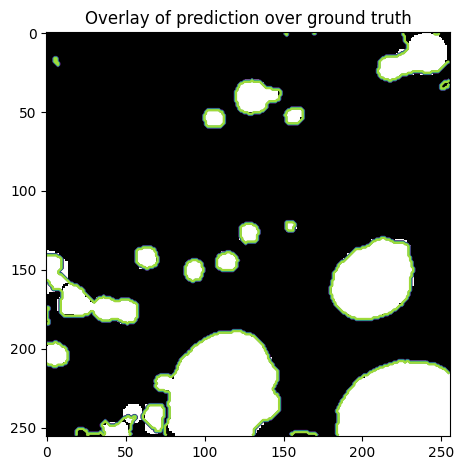

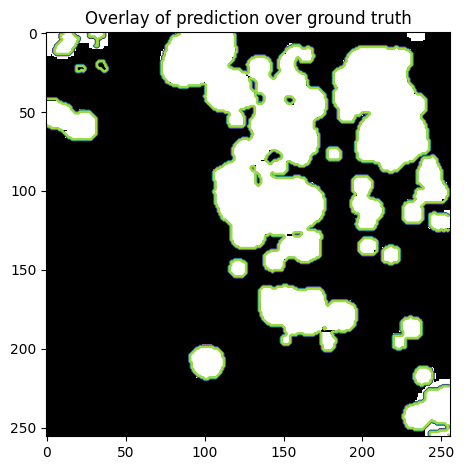

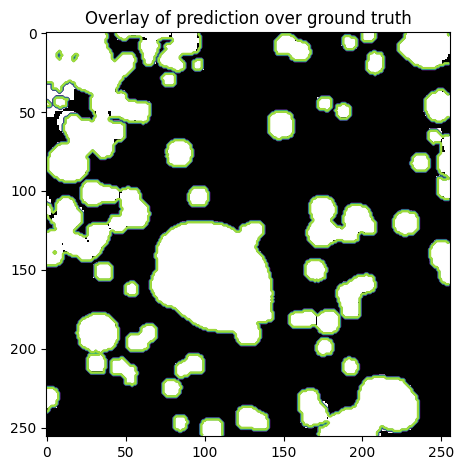

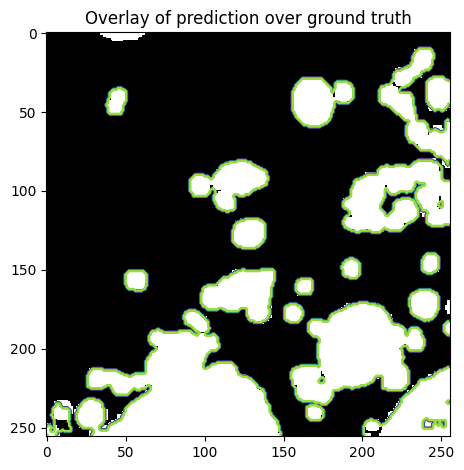

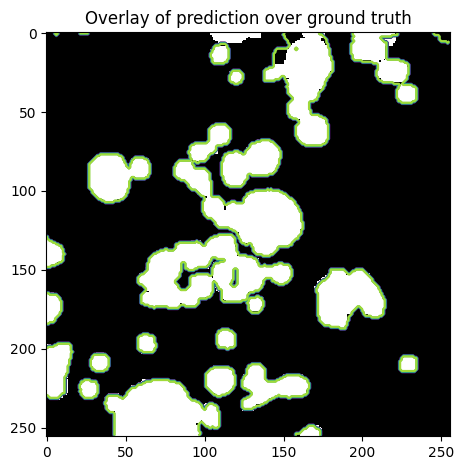

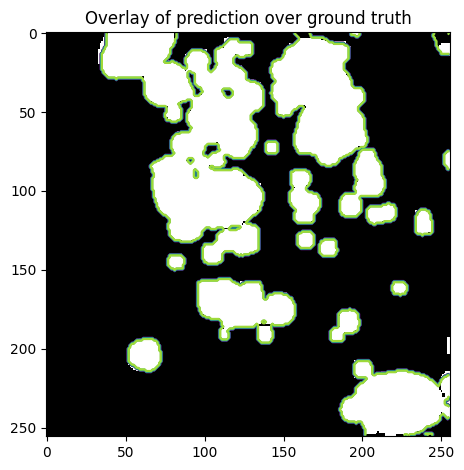

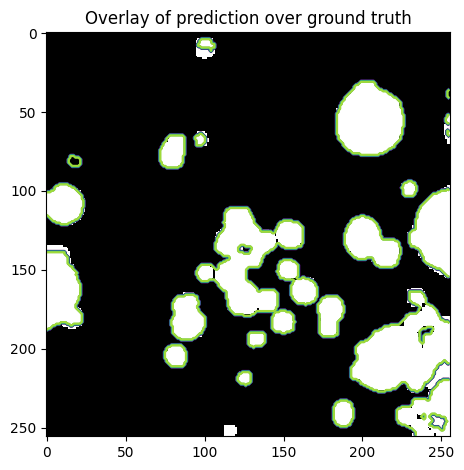

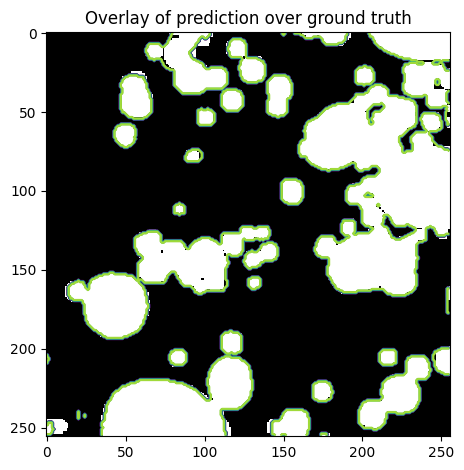

In [10]:
for i in range(10):
    
    ix=random.randint(0,100)
    plt.title('Overlay of prediction over ground truth')
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.contour(np.squeeze(preds_val_t[ix]))
    plt.show()

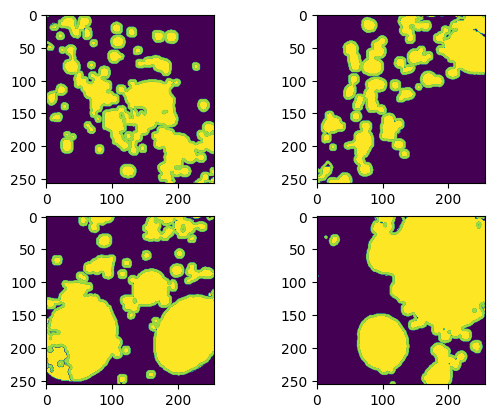

In [17]:
fig, axs = plt.subplots(2, 2)


ix1 = 35
ix2 = 66
ix3 = 43
ix4 = 77



axs[0,0].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix1]))
axs[0,0].contour(np.squeeze(preds_val_t[ix1]))

axs[0,1].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix2]))
axs[0,1].contour(np.squeeze(preds_val_t[ix2]))

axs[1,0].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix3]))
axs[1,0].contour(np.squeeze(preds_val_t[ix3]))

axs[1,1].imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix4]))
axs[1,1].contour(np.squeeze(preds_val_t[ix4]))

plt.savefig('../../../Final Presentation/binary_overlay.png')


In [18]:
!python3 -m tensorboard.main --logdir=logs/

W0406 16:38:21.717175 6160101376 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
